In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from minisom import MiniSom

import numpy as np
import scipy.io as scipio

from timeit import default_timer as timer
import time as tm

import seaborn as sns
import pandas as pd

import itertools

%matplotlib inline

# %load_ext autoreload

%run minisom-master/minisom.py

In [3]:
# load needed files
input_npz = np.load('../Synthetic Model/input_fields.npz')
output_smooth_npz = np.load('../Synthetic Model/output_fields_smooth.npz')
output_npz = np.load('../Synthetic Model/output_fields.npz')

In [198]:
def check_inf_nan(in_data):
    
    #display NaN index
    nan_pos = np.argwhere(np.isnan(in_data))
    print("Index with NaN:\n", nan_pos)

    #display inf index
    inf_pos = np.argwhere(np.isinf(in_data))
    print("Index with inf:\n", inf_pos)
        
def replace_inf_nan(in_data, re_inf=9999):
    print("Replacing inf with", re_inf)
    nan_pos = np.argwhere(np.isnan(in_data))
    inf_pos = np.argwhere(np.isinf(in_data))
    
    #replace nan with number
    in_data = np.nan_to_num(in_data)

    #replace inf with number
    in_data[inf_pos[:,0], inf_pos[:,1]] = re_inf
    return in_data, inf_pos

def normalize_old(in_data):
    norm_data = np.apply_along_axis(lambda x: x/np.linalg.norm(in_data), 1, in_data)
    return norm_data

def normalize(in_data, mean, std):
    norm_data = in_data - mean
    norm_data /= std
    return norm_data

def normalize2(in_data, means, stds):
    for i in range(in_data.shape[1]):
        in_data[:,i] -= means[i]
        in_data[:,i] /= stds[i]
    return in_data

def compute_dim(num_sample):
    dim = 5 * np.sqrt(num_sample)
    dim = np.int(np.sqrt(dim))
    if dim < 10: return 10
    else: return dim
    
def plot_hist(in_data, label, n_class, titles):
    # explore the data
    hist_data = np.append(label, in_data, axis=1)
    print(hist_data.shape)
    df = pd.DataFrame(hist_data,       # values
                      columns=titles[:-2]) # column name
    df.describe()
    # Plot histogram of each graph
    print(n_class)
    fig, ax = plt.subplots(ncols=6, nrows=n_class, figsize=(20,30))
    fig.tight_layout()
    for i in range(6):
        print("Plotting the histogram", titles[i+1], "of each class.")
        df.hist(column=titles[i+1], by=titles[0], figsize=(4,20), ax=ax[:,i]) 
        
    return df.describe()

In [5]:
def som_assemble(in_data, seed, dim, lr=0.5, sigma=2.5):
    # Initialization som and weights
    num_features = np.shape(in_data)[1]
    som = MiniSom(dim, dim, num_features, sigma=sigma, learning_rate=lr, 
                  neighborhood_function='gaussian', random_seed=seed)

    som.pca_weights_init(in_data)
    
    return som

def plot_som(som, norm_data, label, save=False, model_name='temp'):
    plt.figure(figsize=(9,7))
    # Plotting the response for each litho-class
    plt.pcolor(som.distance_map().T, cmap='bone_r')  
    # plotting the distance map as background
    plt.colorbar()

    for t, xx in zip(label, norm_data):
        w = som.winner(xx)  # getting the winner
        # palce a marker on the winning position for the sample xx
        plt.text(w[0]+.5, w[1]+.5, str(t),
                 color=plt.cm.rainbow(t/10.))
        
    plt.axis([0, som.get_weights().shape[0], 0, som.get_weights().shape[1]])
    if(save):
        save_dir = 'SOMs_results/' + model_name + '_plot.png'
        plt.savefig(save_dir)
        print('Plot saved at:', save_dir)
#     plt.show()
    
def write_param(model_name, dim, it, lr, re_inf, et, sigma):
    params = str(model_name) + '\n---' + \
             '\nseed,' + str(seed) + \
             '\ndim,' + str(dim) + \
             '\niterations,' + str(it) + \
             '\nlearning rate,' + str(lr) + \
             '\nsigma,' + str(sigma) + \
             '\ninf,' + str(re_inf) + \
             '\nelapsed time,' + str(et) + '\n\n'
    return params

def save_som(param_vals, som, report, c_matrix, model_name, grid=False, rand=False):
    #save report to file
    fdir, mode = '', ''
    if(grid):
        fdir = 'SOMs_results/grid_search/gridsearch_report.csv'
        mode = 'a+'
    elif(rand):
        fdir = 'SOMs_results/random_search/randomsearch_report.csv'
        mode = 'a+'
    else:
        fdir = 'SOMs_results/' + model_name + '_report.csv'
        mode = 'w'
    f1 = open(fdir, mode) 

    f1.write(param_vals) 
    f1.write(report) 
    f1.write('\nConfusion Matrix\n') 
    np.savetxt(f1, c_matrix,fmt='%i', delimiter=",")
    f1.write('\n\n--------------------\n\n')
    f1.close() #to change file access modes  
    print('Report saved at:', fdir)
    
    #pickle the model
    fdir = 'SOMs_results/' + model_name + '_model.p'
    with open(fdir, 'wb') as outfile:
        pickle.dump(som, outfile)
        
    print('Model saved at:', fdir)

In [215]:
#function to convert npz to 3d numpy array.
def convLabel(label_file):
    label = label_file
    label = np.reshape(label, label.shape[0] * label.shape[1])
    
    print("Class number")
    print(np.shape(label), np.nanmin(label), np.nanmax(label))
    
    return label

def convToNP(data_file):
    init_data = []
    for key in data_file.files:
        val = data_file[key]
        if(len(val.shape)==2):
            print(key)
            print(val.shape, np.nanmin(val), np.nanmax(val))
            val = np.reshape(val, val.shape[0] * val.shape[1])
            
        init_data.append(val)

    # convert X and Z to meshgrid coordinate
    grid_X, grid_Z = np.meshgrid(init_data[-2], init_data[-1])
                                 # X, Z
    del init_data[-1]
    del init_data[-1]
    
    val = np.reshape(grid_X, grid_X.shape[0] * grid_X.shape[1])
    init_data.append(val)
    print("X\n", val.shape, np.nanmin(val), np.nanmax(val))
    
    val = np.reshape(grid_Z, grid_Z.shape[0] * grid_Z.shape[1])
    init_data.append(val)
    print("Z\n",val.shape, np.nanmin(val), np.nanmax(val))
    
    init_data = np.transpose(np.array(init_data))
    print("\nAggregated shape:", init_data.shape)
    return init_data

init_label = convLabel(input_npz['classes'])
init_data = convToNP(output_npz)


Class number
(24000,) 0 9
vp
(100, 240) 1500.0 6839.872834598128
vs
(100, 240) 0.0 3593.8244297758774
dn
(100, 240) 1000.0 2953.6736203709856
vpvs
(100, 240) 1.6846551790318647 inf
qp
(100, 240) 21.287755021839683 1000.0
qs
(100, 240) 5.745752745694737 1000.0
X
 (24000,) 0.0 23900.0
Z
 (24000,) 0.0 9900.0

Aggregated shape: (24000, 8)


In [78]:
print(init_data[:10, 0])  # Vp
print(init_data[:10, -2]) # X
print(init_data[:10, -1]) # Z

[1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500.]
[  0. 100. 200. 300. 400. 500. 600. 700. 800. 900.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [202]:
# data preprocessing
def pre_process(init_data, water_idx, re_inf):
    #check and replace NaN and INF values
#     check_inf_nan(init_data)

    data, inf_pos = replace_inf_nan(init_data, re_inf=re_inf)
#     check_inf_nan(data)

    # priori info = water location
    data = np.delete(data, water_idx, axis=0)
    # capped Vp/Vs ratio to maximum of 10
    vpvs_capped_idx = np.where(data[:,3]>10)
    data[vpvs_capped_idx, 3] = 10
    
    # apply log to Qp and Qs
    data[:,4:6] = np.log(data[:,4:6])
    
    # divide by 1000 on Vp, Vs, and density
    data[:,0:3] = data[:,0:3] / 1000
    
    return data

In [216]:
water_idx = np.where(init_label==0)
label = np.delete(init_label, water_idx)
re_inf = -9999
data = pre_process(init_data, water_idx, re_inf)
print(label.shape)
print(data.shape)

Replacing inf with -9999
(21417,)
(21417, 8)


(21417, 7)
9
Plotting the histogram Vp (m/s) of each class.
Plotting the histogram Vs (m/s) of each class.
Plotting the histogram Density (kg/m$^3$) of each class.
Plotting the histogram Vp/Vs of each class.
Plotting the histogram Qp of each class.
Plotting the histogram Qs of each class.


,Class,Vp (m/s),Vs (m/s),Density (kg/m$^3$),Vp/Vs,Qp,Qs
count,21417.000000,21417.000000,2.141700e+04,21417.000000,21417.000000,21417.000000,21417.000000
mean,6.478825,5.413420,2.878112e+00,2.689786,2.007538,5.411846,4.402791
std,1.964271,0.961021,6.598354e-01,0.207845,0.984307,0.784772,0.800446
min,1.000000,2.511417,1.237275e-08,2.087627,1.684655,3.058132,1.748461
25%,6.000000,5.075739,2.545132e+00,2.597093,1.741168,4.805852,3.866640
50%,7.000000,5.653304,3.162888e+00,2.772905,1.816635,5.677774,4.688128
75%,8.000000,6.065490,3.330595e+00,2.791959,1.928817,6.033377,5.034781
max,9.000000,6.839873,3.593824e+00,2.953674,10.000000,6.659297,5.449047


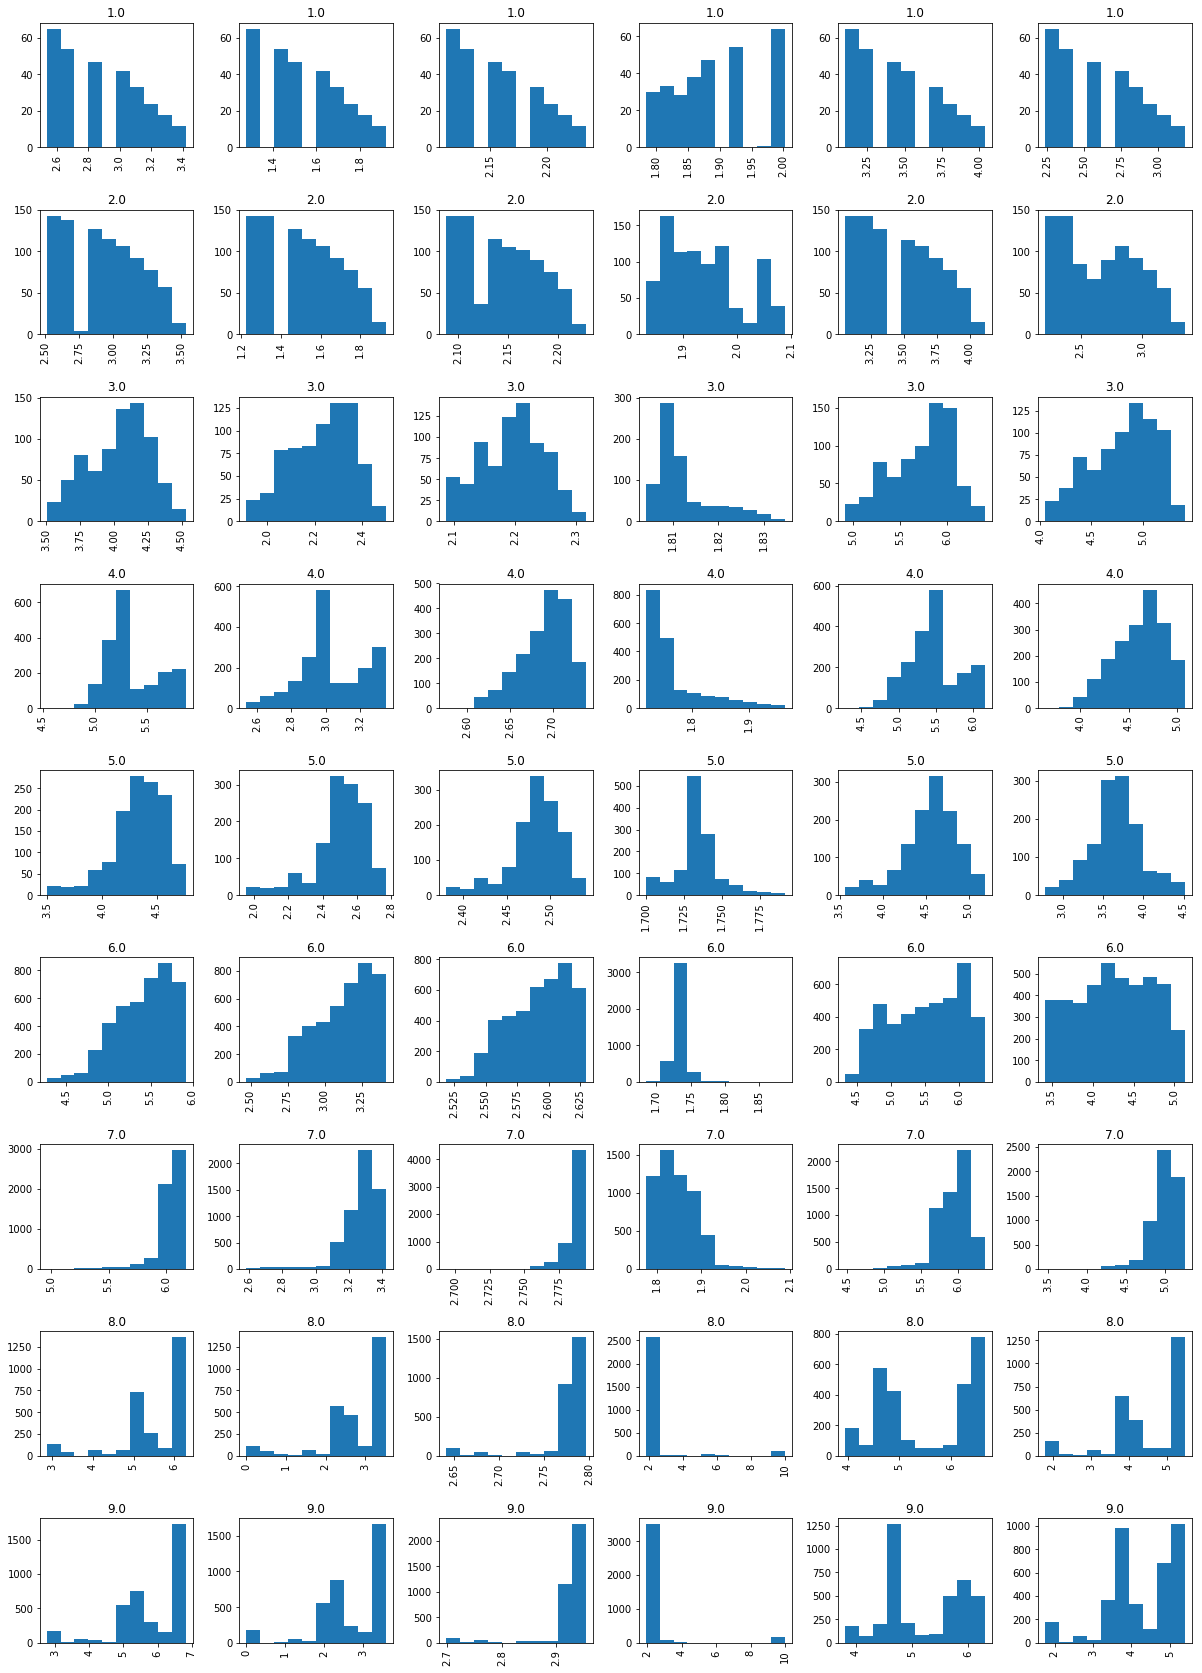

In [217]:
n_class = len(np.unique(label))
titles = ['Class', 'Vp (m/s)', 'Vs (m/s)', 'Density (kg/m$^3$)', 'Vp/Vs', 'Qp', 'Qs', 'X', 'Z']

data_info = plot_hist(data[:,:-2], np.reshape(label, (label.shape[0],1)), n_class, titles)
data_info

In [199]:
means = np.mean(data, axis=0)
stds = np.std(data, axis=0)
norm_data2 = normalize2(data, means, stds)


[5.41341997e+00 2.87811199e+00 2.68978598e+00 2.00753799e+00
 5.41184578e+00 4.40279119e+00 1.19195732e+04 5.48269599e+03]
[9.60998921e-01 6.59819997e-01 2.07840645e-01 9.84284478e-01
 7.84754085e-01 8.00427268e-01 6.88747895e+03 2.58542709e+03]


In [231]:
seed = 10

## data normalization
# norm_data = normalize(data[:,1:])

# # norm 2
# means = np.mean(data, axis=0)
# stds = np.std(data, axis=0)
# norm_data = normalize2(data, means, stds)

# # norm2 no x z
means = np.mean(data[:,:-2], axis=0)
stds = np.std(data[:,:-2], axis=0)
norm_data = normalize2(data[:,:-2], means, stds)

# mean = data[:,:-2].mean()
# std = data[:,:-2].std()
# norm_data = normalize(data[:,:-2], mean, std)
X_train, X_test, y_train, y_test = train_test_split(norm_data, label, random_state=seed)

print("The size of train portion is:" , len(X_train))
print("The size of test portion is:" , len(X_test))

The size of train portion is: 16062
The size of test portion is: 5355


saved file: results/fulltest_nowater_20190704-183418
dim: 34 iter: 4000 lr: 0.5124390316684666 sigma: 2.189655172413793

---------------
elapsed time: 6.605344530020375
             precision    recall  f1-score   support

          1     1.0000    0.7534    0.8594        73
          2     0.9253    1.0000    0.9612       223
          3     1.0000    1.0000    1.0000       167
          4     0.9918    0.9898    0.9908       491
          5     0.9607    0.9638    0.9622       304
          6     0.9866    0.9801    0.9834      1055
          7     0.9415    0.9822    0.9614      1408
          8     0.9366    0.8745    0.9045       693
          9     0.9871    0.9787    0.9829       941

avg / total     0.9654    0.9651    0.9647      5355

[[  55   18    0    0    0    0    0    0    0]
 [   0  223    0    0    0    0    0    0    0]
 [   0    0  167    0    0    0    0    0    0]
 [   0    0    0  486    0    3    2    0    0]
 [   0    0    0    0  293   11    0    0    0]
 [   

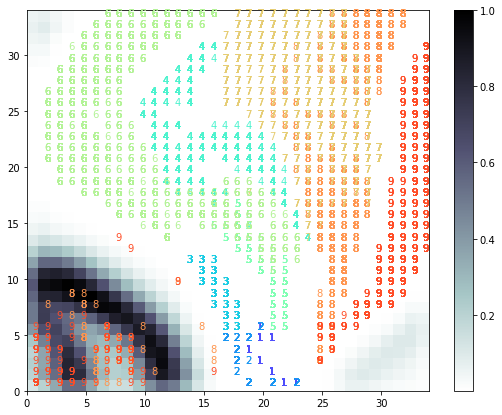

In [175]:
### test SOMs -- old norm
timestr = tm.strftime("%Y%m%d-%H%M%S")

# initialize hyperparameters
dim = 34
iter_cnt = 4000
lr = 0.5124390316684666
sigma = 2.189655172413793

# define model name for saving
model_name = 'results/fulltest_nowater_' + str(timestr)
print('saved file:', model_name)
print('dim:', dim, 'iter:', iter_cnt, 'lr:', lr, 'sigma:',sigma)
print('\n---------------')

som = som_assemble(norm_data, seed, dim, lr, sigma)

start = timer()
som.train_random(X_train, iter_cnt, verbose=False)
end = timer()
elapsed_time = end - start
print('elapsed time:', elapsed_time)

som.labels_map(X_train, y_train)
y_pred = np.array(som.classify(X_test))

report = classification_report(y_test, y_pred, digits=4)
print(report)
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)

param_vals = write_param(model_name, dim, iter_cnt, lr, re_inf, elapsed_time, sigma)
save_som(param_vals, som, report, c_matrix, model_name)
plot_som(som, norm_data, label, model_name=model_name, save=True)

saved file: results/fulltest_nowater_norm_20190707-162431
dim: 34 iter: 4000 lr: 0.5124390316684666 sigma: 2.189655172413793

---------------
elapsed time: 6.723644461999356
             precision    recall  f1-score   support

          1     1.0000    0.7945    0.8855        73
          2     0.9370    1.0000    0.9675       223
          3     1.0000    1.0000    1.0000       167
          4     0.9980    0.9959    0.9969       491
          5     0.9804    0.9868    0.9836       304
          6     0.9943    0.9905    0.9924      1055
          7     0.9398    0.9865    0.9626      1408
          8     0.9696    0.8759    0.9204       693
          9     0.9989    0.9989    0.9989       941

avg / total     0.9750    0.9744    0.9740      5355

[[  58   15    0    0    0    0    0    0    0]
 [   0  223    0    0    0    0    0    0    0]
 [   0    0  167    0    0    0    0    0    0]
 [   0    0    0  489    0    2    0    0    0]
 [   0    0    0    0  300    4    0    0    0]


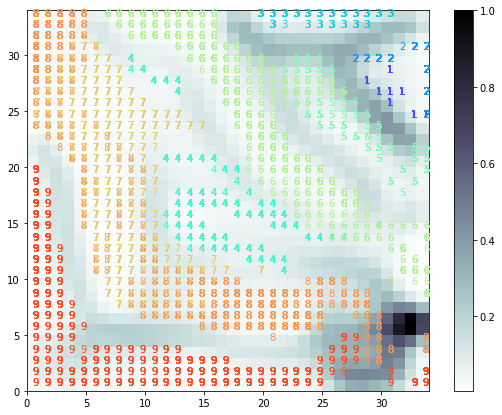

In [228]:
### test SOMs -- new norm
timestr = tm.strftime("%Y%m%d-%H%M%S")

# initialize hyperparameters
dim = 34
iter_cnt = 4000
lr = 0.5124390316684666
sigma = 2.189655172413793

# define model name for saving
model_name = 'results/fulltest_nowater_norm_' + str(timestr)
print('saved file:', model_name)
print('dim:', dim, 'iter:', iter_cnt, 'lr:', lr, 'sigma:',sigma)
print('\n---------------')

som = som_assemble(norm_data, seed, dim, lr, sigma)

start = timer()
som.train_random(X_train, iter_cnt, verbose=False)
end = timer()
elapsed_time = end - start
print('elapsed time:', elapsed_time)

som.labels_map(X_train, y_train)
y_pred = np.array(som.classify(X_test))

report = classification_report(y_test, y_pred, digits=4)
print(report)
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)

param_vals = write_param(model_name, dim, iter_cnt, lr, re_inf, elapsed_time, sigma)
save_som(param_vals, som, report, c_matrix, model_name)
plot_som(som, norm_data, label, model_name=model_name, save=True)

saved file: results/fulltest_nowater_norm2_20190707-162622
dim: 34 iter: 4000 lr: 0.5124390316684666 sigma: 2.189655172413793

---------------
elapsed time: 7.042649163002352
             precision    recall  f1-score   support

          1     1.0000    0.9589    0.9790        73
          2     0.9866    0.9910    0.9888       223
          3     1.0000    0.9940    0.9970       167
          4     0.9780    0.9980    0.9879       491
          5     0.9711    0.9934    0.9821       304
          6     0.9981    0.9896    0.9938      1055
          7     0.9873    0.9943    0.9908      1408
          8     0.9926    0.9697    0.9810       693
          9     0.9968    0.9979    0.9973       941

avg / total     0.9906    0.9905    0.9905      5355

[[  70    3    0    0    0    0    0    0    0]
 [   0  221    0    0    0    0    2    0    0]
 [   0    0  166    0    0    0    1    0    0]
 [   0    0    0  490    0    0    1    0    0]
 [   0    0    0    0  302    2    0    0    0]

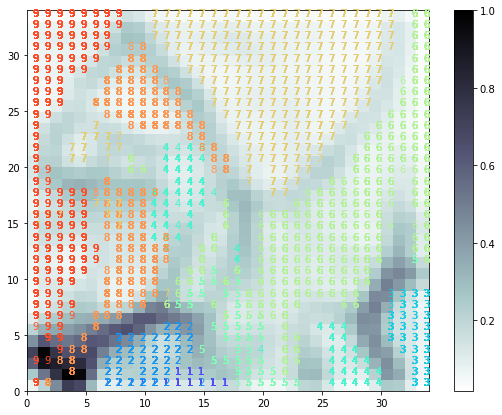

In [230]:
### test SOMs -- new norm2
timestr = tm.strftime("%Y%m%d-%H%M%S")

# initialize hyperparameters
dim = 34
iter_cnt = 4000
lr = 0.5124390316684666
sigma = 2.189655172413793

# define model name for saving
model_name = 'results/fulltest_nowater_norm2_' + str(timestr)
print('saved file:', model_name)
print('dim:', dim, 'iter:', iter_cnt, 'lr:', lr, 'sigma:',sigma)
print('\n---------------')

som = som_assemble(norm_data, seed, dim, lr, sigma)

start = timer()
som.train_random(X_train, iter_cnt, verbose=False)
end = timer()
elapsed_time = end - start
print('elapsed time:', elapsed_time)

som.labels_map(X_train, y_train)
y_pred = np.array(som.classify(X_test))

report = classification_report(y_test, y_pred, digits=4)
print(report)
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)

param_vals = write_param(model_name, dim, iter_cnt, lr, re_inf, elapsed_time, sigma)
save_som(param_vals, som, report, c_matrix, model_name)
plot_som(som, norm_data, label, model_name=model_name, save=True)

saved file: results/fulltest_nowater_norm2noXZ_20190707-162816
dim: 34 iter: 4000 lr: 0.5124390316684666 sigma: 2.189655172413793

---------------
elapsed time: 6.477913988001092
             precision    recall  f1-score   support

          1     1.0000    0.7945    0.8855        73
          2     0.9370    1.0000    0.9675       223
          3     1.0000    1.0000    1.0000       167
          4     0.9980    0.9959    0.9969       491
          5     0.9804    0.9868    0.9836       304
          6     0.9943    0.9905    0.9924      1055
          7     0.9398    0.9865    0.9626      1408
          8     0.9696    0.8759    0.9204       693
          9     0.9989    0.9989    0.9989       941

avg / total     0.9750    0.9744    0.9740      5355

[[  58   15    0    0    0    0    0    0    0]
 [   0  223    0    0    0    0    0    0    0]
 [   0    0  167    0    0    0    0    0    0]
 [   0    0    0  489    0    2    0    0    0]
 [   0    0    0    0  300    4    0    0  

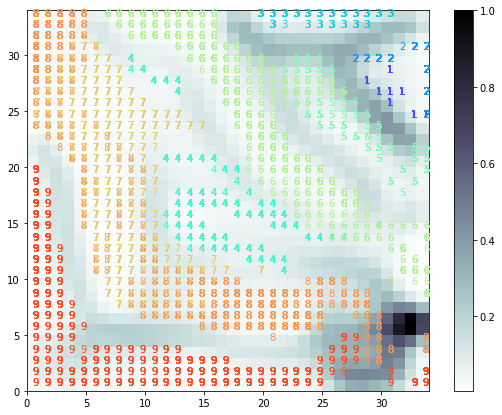

In [232]:
### test SOMs -- new norm2 no x z
timestr = tm.strftime("%Y%m%d-%H%M%S")

# initialize hyperparameters
dim = 34
iter_cnt = 4000
lr = 0.5124390316684666
sigma = 2.189655172413793

# define model name for saving
model_name = 'results/fulltest_nowater_norm2noXZ_' + str(timestr)
print('saved file:', model_name)
print('dim:', dim, 'iter:', iter_cnt, 'lr:', lr, 'sigma:',sigma)
print('\n---------------')

som = som_assemble(norm_data, seed, dim, lr, sigma)

start = timer()
som.train_random(X_train, iter_cnt, verbose=False)
end = timer()
elapsed_time = end - start
print('elapsed time:', elapsed_time)

som.labels_map(X_train, y_train)
y_pred = np.array(som.classify(X_test))

report = classification_report(y_test, y_pred, digits=4)
print(report)
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)

param_vals = write_param(model_name, dim, iter_cnt, lr, re_inf, elapsed_time, sigma)
save_som(param_vals, som, report, c_matrix, model_name)
plot_som(som, norm_data, label, model_name=model_name, save=True)

In [187]:
# log loss and accuracy
y_pred_agg = []
y_pred2_agg = []

for num in list(y_pred):
    t = np.array(np.zeros(n_class))
    t[num-1] = 1
    y_pred_agg.append(list(t))
    
for num in list(y_pred2):
    t = np.array(np.zeros(n_class))
    t[num-1] = 1
    y_pred2_agg.append(list(t))
    
lloss_train = log_loss(y_train, y_pred2_agg, eps=1e-15)
lloss_test = log_loss(y_test, y_pred_agg, eps=1e-15)

y_pred_train = np.array(som.classify(X_train))
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred)

print('====train====')
print('lloss=', lloss_train)
print('overall probability=', np.exp(-lloss_train))
print('accuracy=', train_acc)

print('====test====')
print('lloss=', lloss_test)
print('overall probability=', np.exp(-lloss_test))
print('accuracy=', test_acc)

====train====
lloss= 0.8214302442321013
overall probability= 0.4398021799310016
accuracy= 0.9762171585107707
====test====
lloss= 1.2061160010921272
overall probability= 0.2993577294720466
accuracy= 0.9650793650793651


In [91]:
# log loss and accuracy -- new norm

y_pred_train = np.array(som.classify(X_train))
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred)

y_pred_agg = []
y_pred2_agg = []

for num in list(y_pred):
    t = np.array(np.zeros(n_class))
    t[num-1] = 1
    y_pred_agg.append(list(t))
    
for num in list(y_pred_train):
    t = np.array(np.zeros(n_class))
    t[num-1] = 1
    y_pred2_agg.append(list(t))
    
lloss_train = log_loss(y_train, y_pred2_agg, eps=1e-15)
lloss_test = log_loss(y_test, y_pred_agg, eps=1e-15)


print('====train====')
print('lloss=', lloss_train)
print('overall probability=', np.exp(-lloss_train))
print('accuracy=', train_acc)

print('====test====')
print('lloss=', lloss_test)
print('overall probability=', np.exp(-lloss_test))
print('accuracy=', test_acc)

====train====
lloss= 0.9612024062087663
overall probability= 0.3824327698703892
accuracy= 0.9721703399327606
====test====
lloss= 1.1996661829044688
overall probability= 0.3012947724726967
accuracy= 0.965266106442577


In [220]:
# log loss and accuracy -- new norm2

y_pred_train = np.array(som.classify(X_train))
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred)

y_pred_agg = []
y_pred2_agg = []

for num in list(y_pred):
    t = np.array(np.zeros(n_class))
    t[num-1] = 1
    y_pred_agg.append(list(t))
    
for num in list(y_pred_train):
    t = np.array(np.zeros(n_class))
    t[num-1] = 1
    y_pred2_agg.append(list(t))
    
lloss_train = log_loss(y_train, y_pred2_agg, eps=1e-15)
lloss_test = log_loss(y_test, y_pred_agg, eps=1e-15)


print('====train====')
print('lloss=', lloss_train)
print('overall probability=', np.exp(-lloss_train))
print('accuracy=', train_acc)

print('====test====')
print('lloss=', lloss_test)
print('overall probability=', np.exp(-lloss_test))
print('accuracy=', test_acc)

====train====
lloss= 0.23008648202313367
overall probability= 0.7944648926010703
accuracy= 0.9933383140331217
====test====
lloss= 0.328940727570586
overall probability= 0.7196856730011463
accuracy= 0.9904761904761905


In [ ]:
## parameter tuning
# grid search
def grid_search_som(init_num):
    
    dims = [-5, 0, 5, 10]
    dims += np.array(compute_dim(norm_data.shape[0]))
    idx = np.argwhere(dims<=0)
    if(idx.size!=0):
        dims = dims[idx[-1][0]:]
#    dim = [22, 27, 32, 37]
    iter_cnts = [2000, 4000, 5000, 6000]
    lr = [0.25, 0.5, 0.75]#, 1e-3, 1e-4]
    sigma = [1, 2, 2.5, 3, 4]

# # small grid test
#     dims = [5]
#     iter_cnts = [10, 20]
#     lr = [0.75]
#     sigma = [1]
    
    test_num = init_num
    
    hyperpara = [dims, iter_cnts, lr, sigma]
    hyperpara_perm = list(itertools.product(*hyperpara))
    
    best_acc = 0
    best_comb = []
    best_model = ''
    
    for comb in hyperpara_perm:
        print(comb[0]," ",comb[1], " ", comb[2], " ", comb[3])

        test_num += 1
        model_name = 'grid_search/grid_' + str(test_num)
        
        som = som_assemble(norm_data, seed, comb[0], lr=comb[2], sigma=comb[3])
        
        start = timer()
        som.train_random(X_train, comb[1], verbose=False)
        end = timer()
        elapsed_time = end - start
        
        som.labels_map(X_train, y_train)
        y_pred = np.array(som.classify(X_test))
        curr_acc = accuracy_score(y_test, y_pred)
        
        if(best_acc < curr_acc):
            best_acc = curr_acc
            best_comb = comb
            best_model = model_name
            print('current best model:', best_model)
            print('current best comb:', best_comb)
            print('current best acc:', best_acc)
            
        #save the current model
#         plot_som(som, norm_data, label, save=True, model_name=model_name)
        report = classification_report(y_test, y_pred, digits=4)
        c_matrix = confusion_matrix(y_test, y_pred)

        param_vals = write_param(model_name=model_name, dim=comb[0], it=comb[1], lr=comb[2], re_inf=re_inf, et=elapsed_time, sigma=comb[3])

        save_som(param_vals, som=som, report=report, c_matrix=c_matrix, model_name=model_name, grid=True)
    print('Best model found:', best_model)
    print('Best comb found:', best_comb)
    print('Best acc found:', best_acc)

    return best_comb

In [ ]:
# run gridsearch to find best result
# best_comb = grid_search_som(0)
# print(best_comb)
# dim, iter_cnt, lr, sigma = best_comb

In [26]:
# test load model
filename = 'SOMs_results/results/fulltest_20190703-221446_model.p'
loaded_model = pickle.load(open(filename, 'rb'))

loaded_model.labels_map(X_train, y_train)
y_pred = np.array(loaded_model.classify(X_test))
report = classification_report(y_test, y_pred, digits=4)
print(report)

             precision    recall  f1-score   support

          0     1.0000    1.0000    1.0000       680
          1     1.0000    0.7260    0.8413        73
          2     0.9184    1.0000    0.9574       225
          3     1.0000    1.0000    1.0000       193
          4     0.9876    0.9979    0.9927       480
          5     0.9474    0.9931    0.9697       290
          6     0.9972    0.9787    0.9879      1080
          7     0.9467    0.9790    0.9626      1379
          8     0.9226    0.8791    0.9003       637
          9     0.9905    0.9740    0.9822       963

avg / total     0.9709    0.9705    0.9702      6000



In [27]:
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)

[[ 680    0    0    0    0    0    0    0    0    0]
 [   0   53   20    0    0    0    0    0    0    0]
 [   0    0  225    0    0    0    0    0    0    0]
 [   0    0    0  193    0    0    0    0    0    0]
 [   0    0    0    0  479    0    1    0    0    0]
 [   0    0    0    0    0  288    2    0    0    0]
 [   0    0    0    0    6   16 1057    1    0    0]
 [   0    0    0    0    0    0    0 1350   29    0]
 [   0    0    0    0    0    0    0   68  560    9]
 [   0    0    0    0    0    0    0    7   18  938]]


In [30]:
y_pred2 = np.array(loaded_model.classify(X_train))
report = classification_report(y_train, y_pred2, digits=4)
c_matrix2 = confusion_matrix(y_train, y_pred2)
print(c_matrix2)

[[1903    0    0    0    0    0    0    0    0    0]
 [   0  147   75    0    0    0    0    0    0    0]
 [   0    5  643    0    0    2    0    0    0    0]
 [   0    0    0  552    0    0    0    0    0    0]
 [   0    0    0    0 1404    1    0    0    0    0]
 [   0    0    0    0    0  947    7    0    0    0]
 [   0    0    0    0   15   52 3071    0    0    0]
 [   0    0    0    0    1    0    1 4168   57    0]
 [   0    0    0    0    0    0    0  189 1943    5]
 [   0    0    0    0    0    0    0    0   28 2784]]


In [43]:
def gen_param_grid(ideal_dim):
#     min_dim = ideal_dim - 5 if ideal_dim - 5 > 10 else 10
#     max_dim = ideal_dim * 2 if ideal_dim * 2 > 10 else 20
    min_dim, max_dim = 30, 35
    param_grid = {
        'dim': list(range(min_dim, max_dim+1)),
        'iter_cnt': list(range(4000, 5001, 200)),
        'learning_rate': list(np.logspace(np.log10(0.5), np.log10(0.75), base = 10, num = 100)),
        'sigma': list(np.linspace(2, 2.5, num=30)),
    }
    return param_grid

# random search
def random_search_som(init_num, param_grid, max_evals=10):
    
    test_num = init_num
    
    best_acc = 0
    best_comb = []
    best_model = ''
    random.seed(seed)
    
    for i in range(max_evals):
        
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        c_dim, c_it, c_lr, c_sig = list(random_params.values())
        
        print(c_dim," ",c_it, " ", c_lr, " ", c_sig)

        test_num += 1
        model_name = 'random_search/random_' + str(test_num)
        
        som = som_assemble(norm_data, seed, c_dim, lr=c_lr, sigma=c_sig)
        
        start = timer()
        som.train_random(X_train, c_it, verbose=False)
        end = timer()
        elapsed_time = end - start
        
        som.labels_map(X_train, y_train)
        y_pred = np.array(som.classify(X_test))
        curr_acc = accuracy_score(y_test, y_pred)
        
        if(best_acc < curr_acc):
            best_acc = curr_acc
            best_comb = comb
            best_model = model_name
            print('current best model:', best_model)
            print('current best comb:', best_comb)
            print('current best acc:', best_acc)
            
        #save the current model
#         plot_som(som, norm_data, label, save=True, model_name=model_name)
        report = classification_report(y_test, y_pred, digits=4)
        c_matrix = confusion_matrix(y_test, y_pred)

        param_vals = write_param(model_name=model_name, dim=c_dim, it=c_it, lr=c_lr, re_inf=re_inf, et=elapsed_time, sigma=c_sig)

        save_som(param_vals, som=som, report=report, c_matrix=c_matrix, model_name=model_name, rand=True)
        
    print('Best model found:', best_model)
    print('Best comb found:', best_comb)
    print('Best acc found:', best_acc)

    return best_comb, best_acc

In [44]:
import random

ideal_dim = compute_dim(norm_data.shape[0])
param_grid = gen_param_grid(ideal_dim)
# print(param_grid)
best_comb, best_acc = random_search_som(0, param_grid, max_evals=50)

34   4000   0.6237632470919713   2.2586206896551726
current best model: random_search/random_1
current best comb: [34, 4000, 0.6237632470919713, 2.2586206896551726]
current best acc: 0.968
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_1_model.p
34   4000   0.5561810575911957   2.2413793103448274
current best model: random_search/random_2
current best comb: [34, 4000, 0.5561810575911957, 2.2413793103448274]
current best acc: 0.9725
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_2_model.p
33   4400   0.702428412491486   2.4310344827586206
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_3_model.p
31   4000   0.6551853485522241   2.2586206896551726
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_4_model.p
32   4

Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_43_model.p
33   4600   0.5360532054354206   2.2413793103448274
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_44_model.p
33   4800   0.6314745916857393   2.1724137931034484
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_45_model.p
35   4400   0.7199034710271105   2.2413793103448274
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_46_model.p
33   4400   0.702428412491486   2.2758620689655173
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/random_search/random_47_model.p
34   4200   0.734797661448601   2.1206896551724137
Report saved at: SOMs_results/random_search/randomsearch_report.csv
Model saved at: SOMs_results/

In [45]:
 # test load model
filename = 'SOMs_results/random_search/random_42_model.p'
loaded_model = pickle.load(open(filename, 'rb'))

loaded_model.labels_map(X_train, y_train)
y_pred = np.array(loaded_model.classify(X_test))
report = classification_report(y_test, y_pred, digits=4)
print(report)

             precision    recall  f1-score   support

          0     1.0000    1.0000    1.0000       680
          1     1.0000    0.7260    0.8413        73
          2     0.9184    1.0000    0.9574       225
          3     1.0000    1.0000    1.0000       193
          4     0.9917    0.9958    0.9938       480
          5     0.9600    0.9931    0.9763       290
          6     0.9981    0.9815    0.9897      1080
          7     0.9488    0.9935    0.9706      1379
          8     0.9561    0.8885    0.9211       637
          9     0.9916    0.9772    0.9843       963

avg / total     0.9762    0.9757    0.9753      6000



In [46]:
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)

[[ 680    0    0    0    0    0    0    0    0    0]
 [   0   53   20    0    0    0    0    0    0    0]
 [   0    0  225    0    0    0    0    0    0    0]
 [   0    0    0  193    0    0    0    0    0    0]
 [   0    0    0    0  478    0    0    2    0    0]
 [   0    0    0    0    0  288    2    0    0    0]
 [   0    0    0    0    3   12 1060    5    0    0]
 [   0    0    0    0    1    0    0 1370    8    0]
 [   0    0    0    0    0    0    0   63  566    8]
 [   0    0    0    0    0    0    0    4   18  941]]


In [47]:
y_pred2 = np.array(loaded_model.classify(X_train))
report = classification_report(y_train, y_pred2, digits=4)
c_matrix2 = confusion_matrix(y_train, y_pred2)
print(c_matrix2)

[[1903    0    0    0    0    0    0    0    0    0]
 [   0  147   75    0    0    0    0    0    0    0]
 [   0    0  650    0    0    0    0    0    0    0]
 [   0    0    0  552    0    0    0    0    0    0]
 [   0    0    0    0 1399    1    4    1    0    0]
 [   0    0    0    0    0  949    5    0    0    0]
 [   0    0    0    0   11   58 3069    0    0    0]
 [   0    0    0    0    3    0    1 4173   50    0]
 [   0    0    0    0    0    0    0  176 1946   15]
 [   0    0    0    0    0    0    0    0   23 2789]]


Plot saved at: SOMs_results/random_42__plot.png


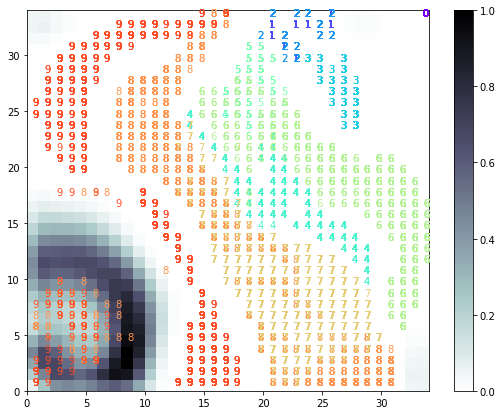

In [49]:
plot_som(loaded_model, norm_data, label, model_name="random_42", save=True)

In [50]:
train_acc = accuracy_score(y_train, y_pred2)
test_acc = accuracy_score(y_test, y_pred)
print(train_acc,'\t', test_acc)

0.9765 	 0.9756666666666667


In [54]:
#test heatmap
import seaborn as sns
import pandas as pd

In [76]:
litos = np.asarray([
    'Water',
    'Siltstone',
    'Clastics',
    'Lavas',
    'Intrusions',
    'Metasediments',
    'Upper_crust',
    'Lower_crust',
    'Diorite',
    'Gabbro'])

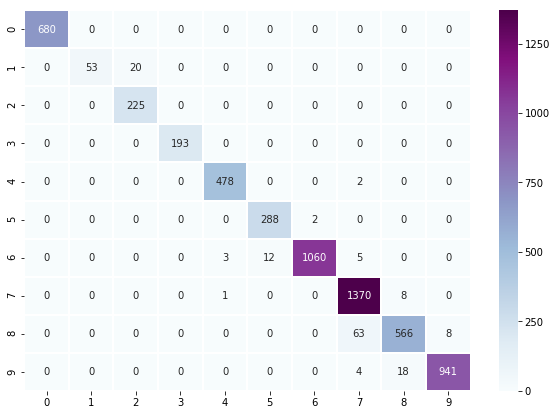

In [74]:
fig, ax = plt.subplots(figsize=(10,7))         # Sample figsize in inches
sns.heatmap(c_matrix.astype(int),annot=True,linewidths=1, ax=ax, fmt='g', cmap="BuPu")

In [75]:
print(X_train.shape, X_test.shape)#, y_train, y_test

(18000, 6) (6000, 6)


In [107]:
#naive bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred3 = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0],(y_test != y_pred3).sum()))

acc3 = 100 * (y_test == y_pred3).sum() / X_test.shape[0]
print("Accuracy of : %.2f" % (acc3))

Number of mislabeled points out of a total 5355 points : 667
Accuracy of : 87.54


In [108]:
#multinomial naive bayes
from sklearn.naive_bayes import MultinomialNB
# X = np.random.randint(5, size=(6, 100))
# y = np.array([1, 2, 3, 4, 5, 6])
clf = MultinomialNB()
clf.fit(norm_data, label)

print(clf.predict(norm_data[2:3]))

ValueError: Input X must be non-negative

In [109]:
neg_idx = np.where(norm_data < 0.0)
print(neg_idx)

(array([    0,     0,     0, ..., 21416, 21416, 21416]), array([0, 1, 2, ..., 1, 2, 3]))
